In [27]:
import numpy as np
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve, Functional
)
from skfem.assembly import LinearForm

from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace
from skfem.visuals.matplotlib import plot
from skfem.helpers import laplacian
import matplotlib.pyplot as plt


In [28]:
def graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True)
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')

    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True)
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True)
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True)
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

def graficar_laplaciano(mesh, lap_u_x, lap_u_y, lap_p):

    plt.figure(figsize=(8,6))
    scatter_ux = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_u_x, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_ux, label='$\\Delta u_x$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta u_x$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

    # Laplaciano de u_y
    plt.figure(figsize=(8,6))
    scatter_uy = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_u_y, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_uy, label='$\\Delta u_y$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta u_y$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

    # Laplaciano de la presión
    plt.figure(figsize=(8,6))
    scatter_p = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_p, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_p, label='$\\Delta p$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta p$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

# Test de Kovasznay

In [29]:
# Definir dominio y mallado
nx, ny = 8, 8
mesh = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)
mesh = mesh.with_boundaries({
    'left':   lambda x: x[0] == 0.0,
    'right':  lambda x: x[0] == 1.0,
    'bottom': lambda x: x[1] == 0.0,
    'top':    lambda x: x[1] == 1.0,
})
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=3),
    'p': Basis(mesh, element['p'], intorder=3),
}

basis_u = basis['u']
basis_p = basis['p']
Nu      = basis_u.N
Np      = basis_p.N

In [39]:
# Perfiles exacto
nu   = 0.1
Re   = 1/nu
lamb = Re/2-np.sqrt(Re*Re/4+4*np.pi*np.pi)

def u_exact_x(x, y):
    return 1- np.exp(lamb*x)*np.cos(2*np.pi*y)

def u_exact_y(x, y):
    return  lamb/(2*np.pi)*np.exp(lamb*x)*np.sin(2*np.pi*y)

def p_exact_xy(x, y):
    return 0.5*np.exp(2*lamb*x) + 0*y

def f_exact_x(x, y):
    return (nu * (lamb**2 - 4*np.pi**2) * np.exp(lamb*x) * np.cos(2*np.pi*y)
            + lamb * np.exp(2*lamb*x))

def f_exact_y(x, y):
    return (-nu * lamb * (lamb**2 - 4*np.pi**2) / (2*np.pi)
            * np.exp(lamb*x) * np.sin(2*np.pi*y))

In [40]:
# Ensamblaje de matrices
A =  nu *asm(vector_laplace, basis['u'])
B = -asm(divergence, basis['u'], basis['p'])

K = bmat([[A, B.T],
          [B, None]], format='csr')

In [41]:
x_boundary = np.zeros(Nu + Np)

# Fronteras de la velocidad

# Obtener DOFs de las fronteras de la base de velocidad
dofs_left     = basis_u.get_dofs('left').all()
dofs_right    = basis_u.get_dofs('right').all()
dofs_top      = basis_u.get_dofs('top').all()
dofs_bottom   = basis_u.get_dofs('bottom').all()

# Elementos con condiciones de Dirichlet para la velocidad
# Impares y, pares x
y_left   = basis_u.doflocs[1, dofs_left[1::2]] 
y_right  = basis_u.doflocs[1, dofs_right[1::2]]

x_left   = basis_u.doflocs[0, dofs_left[::2]]  
x_right  = basis_u.doflocs[0, dofs_right[::2]]

x_top    = basis_u.doflocs[0, dofs_top[::2]]
x_bottom = basis_u.doflocs[0, dofs_bottom[::2]]

y_top    = basis_u.doflocs[1, dofs_top[1::2]]
y_bottom = basis_u.doflocs[1, dofs_bottom[1::2]]


x_boundary[dofs_left[::2]]    =  u_exact_x(x_left, y_left)  # componente x
x_boundary[dofs_left[1::2]]   =  u_exact_y(x_left, y_left)  # componente y

x_boundary[dofs_right[::2]]   =  u_exact_x(x_right, y_right)  # componente x
x_boundary[dofs_right[1::2]]  =  u_exact_y(x_right, y_right)  # componente y

x_boundary[dofs_top[::2]]     =  u_exact_x(x_top, y_top)  # componente x
x_boundary[dofs_top[1::2]]    =  u_exact_y(x_top, y_top)  # componente y

x_boundary[dofs_bottom[::2]]  =  u_exact_x(x_bottom, y_bottom)  # componente x
x_boundary[dofs_bottom[1::2]] =  u_exact_y(x_bottom, y_bottom)  # componente y

dofs_u_boundary = np.concatenate([
    dofs_left,
    dofs_right,
    dofs_top,
    dofs_bottom
])

In [42]:
# Obtener DOFs de las fronteras de la base de velocidad
dofs_left_p     = basis_p.get_dofs('left').all()
dofs_right_p    = basis_p.get_dofs('right').all()
dofs_top_p      = basis_p.get_dofs('top').all()
dofs_bottom_p   = basis_p.get_dofs('bottom').all()

# x_boundary[Nu + dofs_left_p]    = p_exact_xy(basis_p.doflocs[0, dofs_left_p]  , basis_p.doflocs[1, dofs_left_p]  )
# x_boundary[Nu + dofs_right_p]   = p_exact_xy(basis_p.doflocs[0, dofs_right_p] , basis_p.doflocs[1, dofs_right_p] )
# # x_boundary[Nu + dofs_top_p]     = p_exact_xy(basis_p.doflocs[0, dofs_top_p]   , basis_p.doflocs[1, dofs_top_p]   )
# x_boundary[Nu + dofs_bottom_p]  = p_exact_xy(basis_p.doflocs[0, dofs_bottom_p], basis_p.doflocs[1, dofs_bottom_p])
x_boundary[Nu + 0] =  0.5
dofs_p_boundary = Nu + np.concatenate([np.array([0])
    # dofs_left_p,
    # dofs_right_p,
    # dofs_top_p,
    # dofs_bottom_p
])

In [43]:
D_all = np.unique(np.concatenate([dofs_u_boundary, dofs_p_boundary]))

In [44]:
@LinearForm
def rhs_u(v, w):
    x, y = w.x
    fx = f_exact_x(x, y)
    fy = f_exact_y(x, y)
    return fx * v[0] + fy * v[1]

b_u = asm(rhs_u, basis_u) 
b_p = np.zeros(Np)  
F   = np.concatenate([b_u, b_p])

In [45]:
# Resolver sistema condensado
sol_full = solve(*condense(K, F, D=D_all, x=x_boundary))

# Extraer soluciones
u_sol = sol_full[:Nu]
p_sol = sol_full[Nu:]

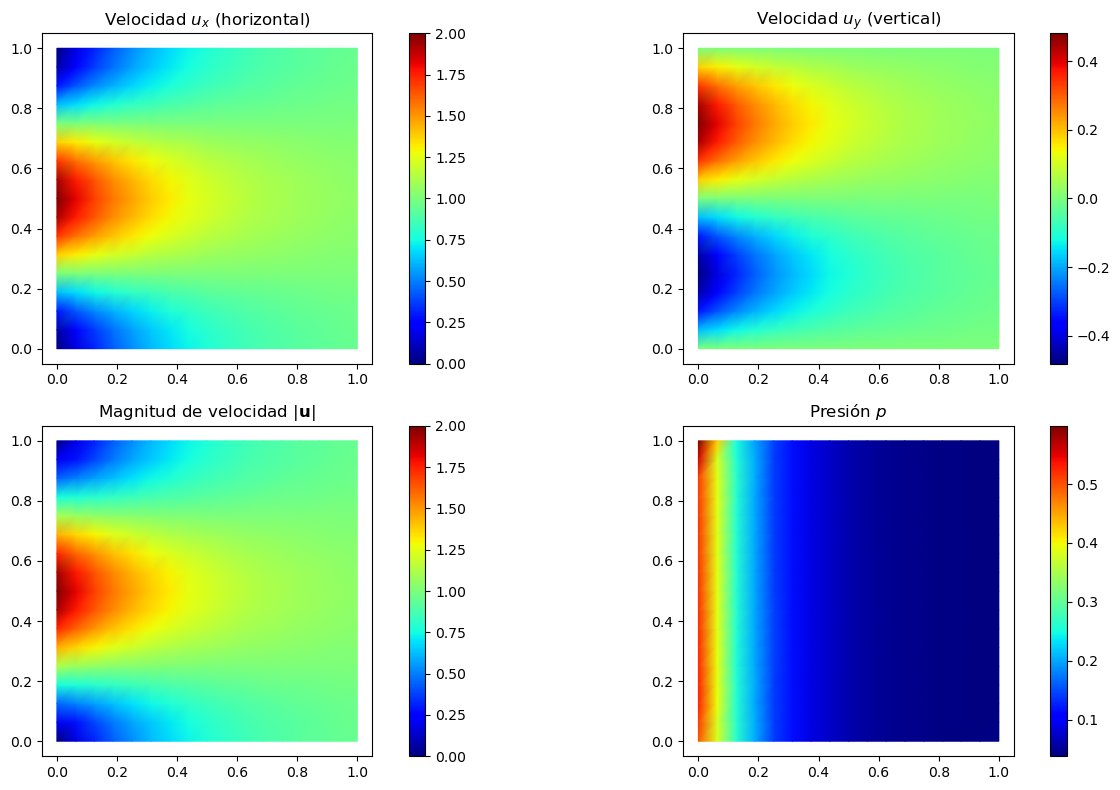

In [46]:
graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u)

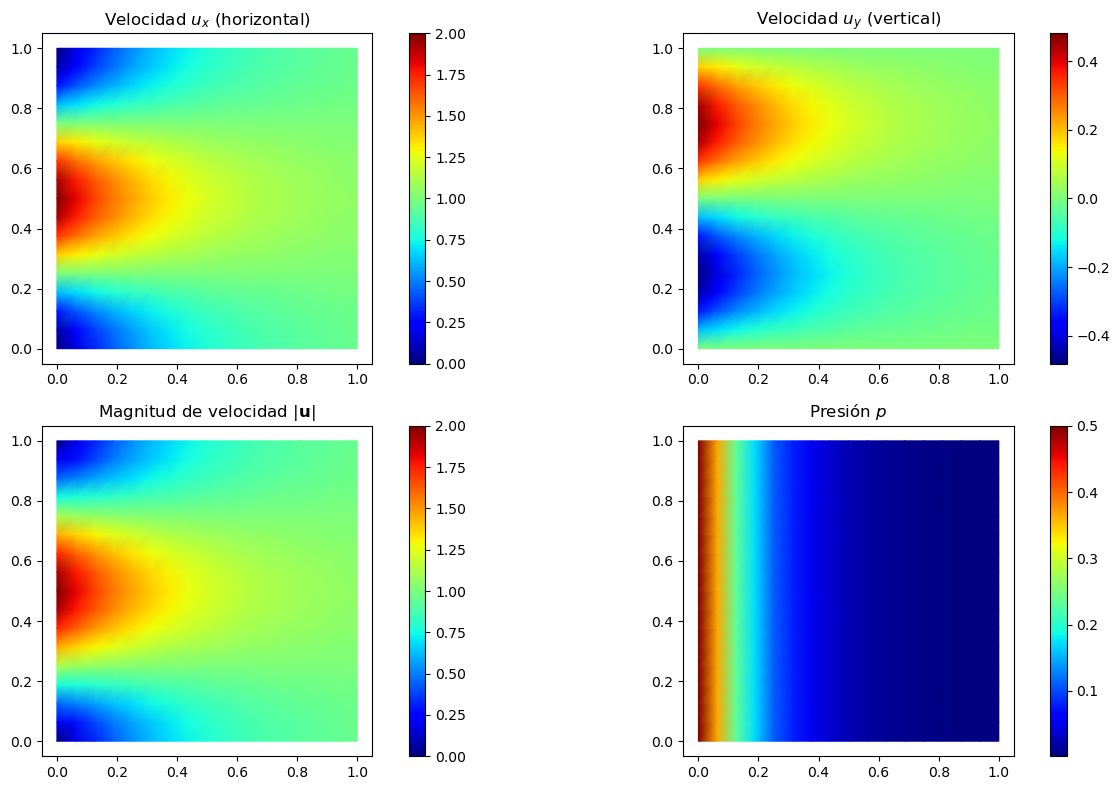

In [47]:
# Construir solucion exacta velocidad
def construir_u_exacta(basis_u):
    Nu = basis_u.N
    u_sol = np.zeros(Nu)

    x_u = basis_u.doflocs[0]  # coordenadas x de todos los DOFs de velocidad
    y_u = basis_u.doflocs[1]  # coordenadas y de todos los DOFs de velocidad

    # DOFs pares: componente x de la velocidad
    u_sol[0::2] = u_exact_x(x_u[0::2], y_u[0::2])
    # DOFs impares: componente y de la velocidad
    u_sol[1::2] = u_exact_y(x_u[1::2], y_u[1::2])

    return u_sol

# Construir solucion exacta presion
def construir_p_exacta(basis_p):
    Np = basis_p.N
    p_sol = np.zeros(Np)

    x_p = basis_p.doflocs[0]  # coordenadas x de los DOFs de presion
    y_p = basis_p.doflocs[1]  # coordenadas y de los DOFs de presion

    p_sol[:] = p_exact_xy(x_p, y_p)

    return p_sol

# Construir y graficar
u_sol = construir_u_exacta(basis_u)
p_sol = construir_p_exacta(basis_p)

graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u)


# Test sin cos

In [48]:
# Definir dominio y mallado
nx, ny = 8, 8
mesh = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)
mesh = mesh.with_boundaries({
    'left':   lambda x: x[0] == 0.0,
    'right':  lambda x: x[0] == 1.0,
    'bottom': lambda x: x[1] == 0.0,
    'top':    lambda x: x[1] == 1.0,
})
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=3),
    'p': Basis(mesh, element['p'], intorder=3),
}

basis_u = basis['u']
basis_p = basis['p']
Nu      = basis_u.N
Np      = basis_p.N

In [49]:
# Perfiles exacto

def u_exact_x(x, y):
    return 2*np.pi*np.sin(2*np.pi*x)*np.cos(2*np.pi*y)

def u_exact_y(x, y):
    return -2*np.pi*np.cos(2*np.pi*x)*np.sin(2*np.pi*y)

def p_exact_xy(x, y):
    return np.sin(2*np.pi*x)*np.sin(2*np.pi*y)

def f_exact_x(x, y):
    return (16 * np.pi**3 * np.sin(2*np.pi*x) * np.cos(2*np.pi*y)
            + 2 * np.pi * np.cos(2*np.pi*x) * np.sin(2*np.pi*y))

def f_exact_y(x, y):
    return (-16 * np.pi**3 * np.cos(2*np.pi*x) * np.sin(2*np.pi*y)
            + 2 * np.pi * np.sin(2*np.pi*x) * np.cos(2*np.pi*y))


In [50]:
# Ensamblaje de matrices
A =  asm(vector_laplace, basis['u'])
B = -asm(divergence, basis['u'], basis['p'])

K = bmat([[A, B.T],
          [B, None]], format='csr')

In [51]:
x_boundary = np.zeros(Nu + Np)

# Fronteras de la velocidad

# Obtener DOFs de las fronteras de la base de velocidad
dofs_left     = basis_u.get_dofs('left').all()
dofs_right    = basis_u.get_dofs('right').all()
dofs_top      = basis_u.get_dofs('top').all()
dofs_bottom   = basis_u.get_dofs('bottom').all()

# Elementos con condiciones de Dirichlet para la velocidad
# Impares y, pares x
y_left   = basis_u.doflocs[1, dofs_left[1::2]] 
y_right  = basis_u.doflocs[1, dofs_right[1::2]]

x_left   = basis_u.doflocs[0, dofs_left[::2]]  
x_right  = basis_u.doflocs[0, dofs_right[::2]]

x_top    = basis_u.doflocs[0, dofs_top[::2]]
x_bottom = basis_u.doflocs[0, dofs_bottom[::2]]

y_top    = basis_u.doflocs[1, dofs_top[1::2]]
y_bottom = basis_u.doflocs[1, dofs_bottom[1::2]]


x_boundary[dofs_left[::2]]    =  u_exact_x(x_left, y_left)  # componente x
x_boundary[dofs_left[1::2]]   =  u_exact_y(x_left, y_left)  # componente y

x_boundary[dofs_right[::2]]   =  u_exact_x(x_right, y_right)  # componente x
x_boundary[dofs_right[1::2]]  =  u_exact_y(x_right, y_right)  # componente y

x_boundary[dofs_top[::2]]     =  u_exact_x(x_top, y_top)  # componente x
x_boundary[dofs_top[1::2]]    =  u_exact_y(x_top, y_top)  # componente y

x_boundary[dofs_bottom[::2]]  =  u_exact_x(x_bottom, y_bottom)  # componente x
x_boundary[dofs_bottom[1::2]] =  u_exact_y(x_bottom, y_bottom)  # componente y

dofs_u_boundary = np.concatenate([
    dofs_left,
    dofs_right,
    dofs_top,
    dofs_bottom
])

In [52]:
# Obtener DOFs de las fronteras de la base de velocidad
dofs_left_p     = basis_p.get_dofs('left').all()
dofs_right_p    = basis_p.get_dofs('right').all()
dofs_top_p      = basis_p.get_dofs('top').all()
dofs_bottom_p   = basis_p.get_dofs('bottom').all()

# x_boundary[Nu + dofs_left_p]    = p_exact_xy(basis_p.doflocs[0, dofs_left_p]  , basis_p.doflocs[1, dofs_left_p]  )
# x_boundary[Nu + dofs_right_p]   = p_exact_xy(basis_p.doflocs[0, dofs_right_p] , basis_p.doflocs[1, dofs_right_p] )
# x_boundary[Nu + dofs_top_p]     = p_exact_xy(basis_p.doflocs[0, dofs_top_p]   , basis_p.doflocs[1, dofs_top_p]   )
# x_boundary[Nu + dofs_bottom_p]  = p_exact_xy(basis_p.doflocs[0, dofs_bottom_p], basis_p.doflocs[1, dofs_bottom_p])
x_boundary[Nu + 0]  = 0
dofs_p_boundary = Nu + np.concatenate([np.array([0])
])

In [53]:
D_all = np.unique(np.concatenate([dofs_u_boundary, dofs_p_boundary]))

In [54]:
@LinearForm
def rhs_u(v, w):
    x, y = w.x
    fx = f_exact_x(x, y)
    fy = f_exact_y(x, y)
    return fx * v[0] + fy * v[1]

b_u = asm(rhs_u, basis_u) 
b_p = np.zeros(Np)  
F   = np.concatenate([b_u, b_p])

In [55]:
# Resolver sistema condensado
sol_full = solve(*condense(K, F, D=D_all, x=x_boundary))

# Extraer soluciones
u_sol = sol_full[:Nu]
p_sol = sol_full[Nu:]

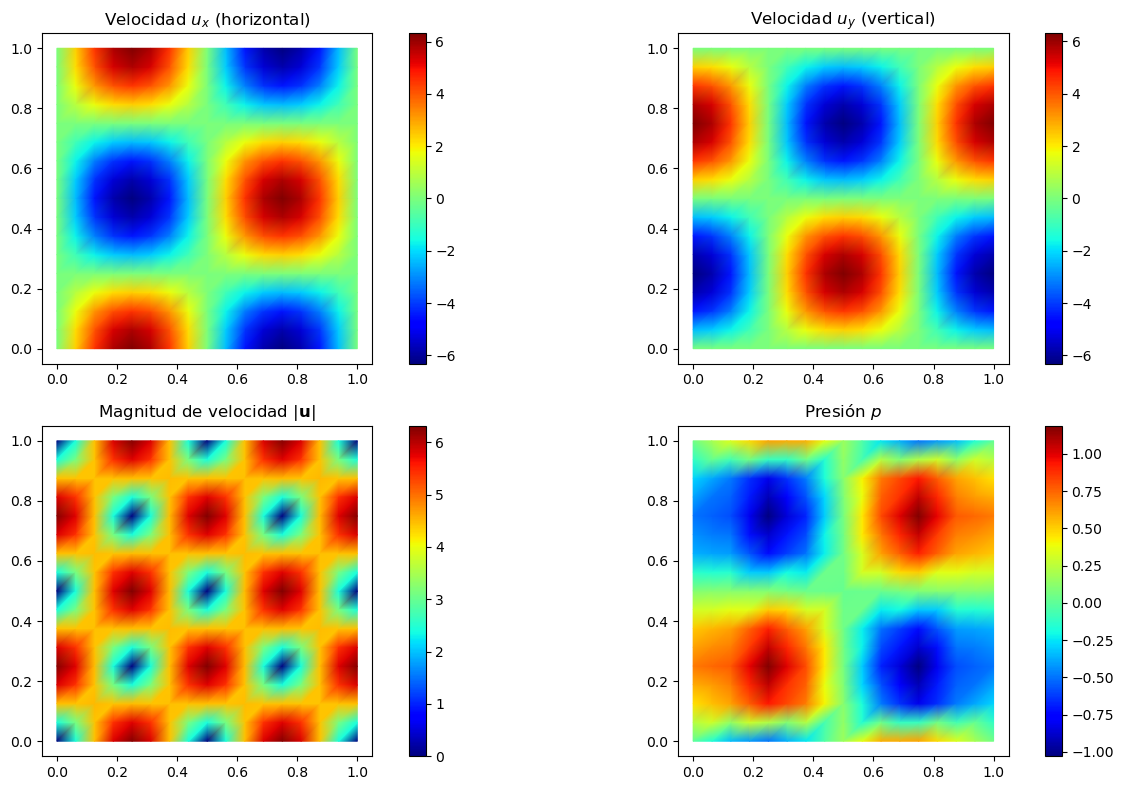

In [56]:
graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u)

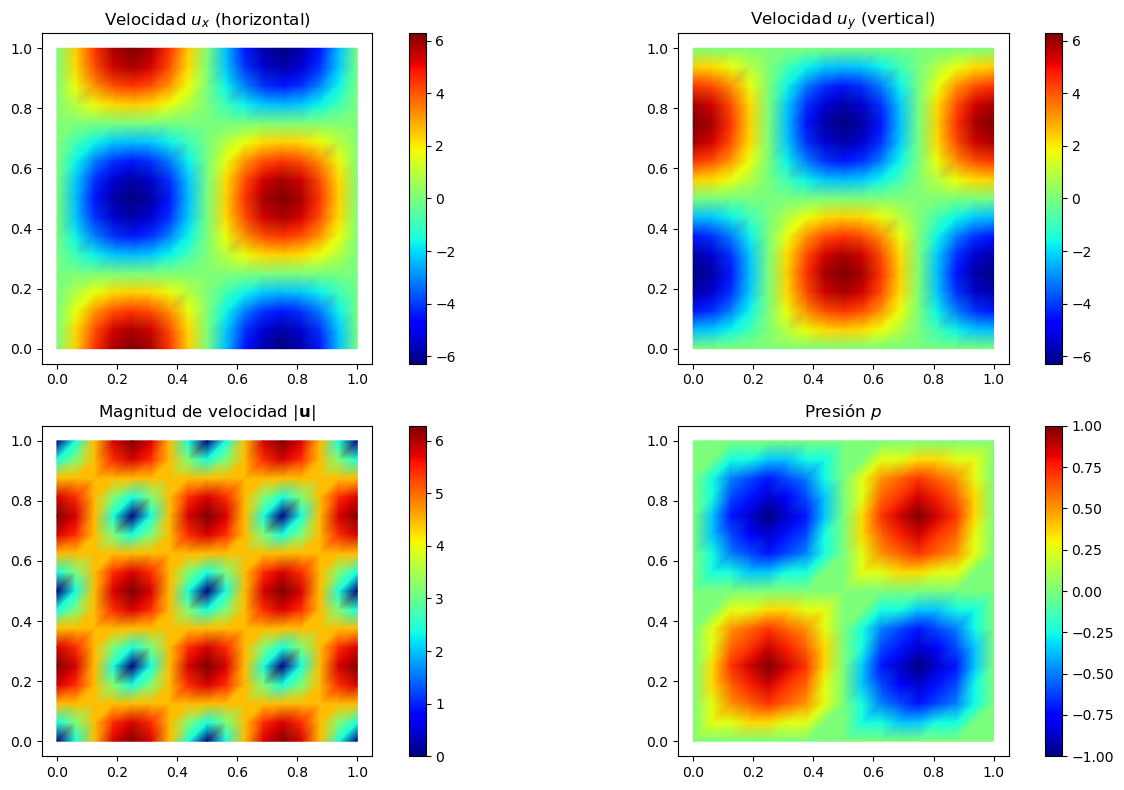

In [57]:
# Construir solucion exacta velocidad
def construir_u_exacta(basis_u):
    Nu = basis_u.N
    u_sol = np.zeros(Nu)

    x_u = basis_u.doflocs[0]  # coordenadas x de todos los DOFs de velocidad
    y_u = basis_u.doflocs[1]  # coordenadas y de todos los DOFs de velocidad

    # DOFs pares: componente x de la velocidad
    u_sol[0::2] = u_exact_x(x_u[0::2], y_u[0::2])
    # DOFs impares: componente y de la velocidad
    u_sol[1::2] = u_exact_y(x_u[1::2], y_u[1::2])

    return u_sol

# Construir solucion exacta presion
def construir_p_exacta(basis_p):
    Np = basis_p.N
    p_sol = np.zeros(Np)

    x_p = basis_p.doflocs[0]  # coordenadas x de los DOFs de presion
    y_p = basis_p.doflocs[1]  # coordenadas y de los DOFs de presion

    p_sol[:] = p_exact_xy(x_p, y_p)

    return p_sol

# Construir y graficar
u_sol = construir_u_exacta(basis_u)
p_sol = construir_p_exacta(basis_p)

graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u)
